# Importing packages:

In [209]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import datetime
import uuid
import matplotlib.pyplot as plt
import matplotlib
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import Polygon as Polygon2
import contextily as ctx
from sklearn.cluster import KMeans
import folium

# Finding stationary scooters for one day (10/1):

## Reading data from database:

In [3]:
# Creating a connection with the database
engine = create_engine('postgresql://himanshuagarwal:@localhost/scooterapi')

# 1. Reading data from database onto a dataframe 'df'.
# 2. Combining date and time features to 'date_time' and converting to datetime datatype for manipulating based on date & time. 
df  = pd.read_sql_query('select * FROM birds_dc',con=engine)
df['date_time'] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)
df['date_time'] = pd.to_datetime(df.date_time)

In [5]:
#---> Can improve the code above, to get only the data that I need instead of getting all the data.

In [6]:
#Getting data for 1st of October.
df_10_1 = df.loc[((df['date_time']>= '2019-10-1 07:00:00')&(df['date_time']<= '2019-10-1 07:15:00')) | ((df['date_time']>= '2019-10-1 23:45:00')&(df['date_time']<= '2019-10-1 23:59:00'))]
df_10_1 = df_10_1.reset_index(drop=True)

## Identifying scooters that were stationary for the day:

### Splitting data to identify stationarity

In [7]:
##Fetching scooter data in the morning between 7 to 7.15am and in the night between 11.45 to 11.59pm
df_10_1_morning = df.loc[((df['date_time']>= '2019-10-1 07:00:00')&(df['date_time']<= '2019-10-1 07:15:00'))]
df_10_1_evening = df.loc[((df['date_time']>= '2019-10-1 23:45:00')&(df['date_time']<= '2019-10-1 23:59:00'))]
df_10_1_morning = df_10_1_morning.reset_index(drop=True)
df_10_1_evening = df_10_1_evening.reset_index(drop=True)

### Combining latitude, longitude to a tuple:

In [9]:
##Converting latitude and longitude columns to tuples
df_10_1_morning['lats_tups'] = list(zip(df_10_1_morning['latitude'],df_10_1_morning['longitude']))
df_10_1_evening['lats_tups'] = list(zip(df_10_1_evening['latitude'],df_10_1_evening['longitude']))

### Scooters present in the morning time:

In [8]:
##Totscoots is all the unique scooter ids present in the above timeframe
TotScootsUUID = []; TotScootsUUID= df_10_1_morning['id'].unique().tolist()
##To convert the format of ids from UUID in TotScootsUUID to strings in TotScoots
TotScoots = []
for i,n in enumerate(TotScootsUUID):
    a = TotScootsUUID[i].urn.split(':')
    TotScoots.append(a[2])

In [13]:
#Number of scooters present in the morning:
len(TotScoots)

953

### Scooters stationary throughout the day:

In [10]:
#To make a dataframe 'lats' containing information of scooters and if had the
#same coordinate throughout the day.
df_10_1_morning['id'] = df_10_1_morning['id'].astype(str)
df_10_1_evening['id'] = df_10_1_evening['id'].astype(str)
lats = pd.DataFrame(columns=['id','Count of lats'])
lens = []
for i,n in enumerate(TotScoots):
    lens.append(n)
    lens.append(df_10_1_evening.loc[(df_10_1_evening['id']== n,'lats_tups')].nunique())
    lats = lats.append({'id':lens[0],'Count of lats':lens[1]},ignore_index=True)
    lens = []

In [11]:
#No. of stationary scooters for 10/1:
print(len(lats[lats['Count of lats']==1]))

198


In [17]:
#Information of stationary scooters as a dataframe - StatScoots
StatScoots = pd.DataFrame(columns=['id'])
StatScootsList = lats.loc[(lats['Count of lats']==1,'id')].tolist()
StatScoots = StatScoots.append([{'id': i} for i in StatScootsList],ignore_index=True)
StatScootsFinal = df_10_1_morning.merge(StatScoots, how = 'inner', on='id')
StatScootsFinal.drop_duplicates(subset='id',keep='first',inplace=True)

In [19]:
#Scooters that were stationary from the scooters that were present in the morning
StatScootsFinal.head(2)

Date  Origin_Dist      Time                          area_key  \
0  2019-10-01     1.161393  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   
3  2019-10-01     1.385419  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   

   battery_level                             bounty_id  captive  code  \
0             35  a3941a05-f317-47f3-a02d-086a1213b6e8    False  None   
3             71                                  None    False  None   

   estimated_range                                    id   latitude  \
0             4247  0c01616a-0fd9-4b6a-bbb0-f9964345d06f  38.936431   
3             8631  a6183867-8ab9-4d4d-9a64-580d887432aa  38.940294   

   longitude model nest_id vehicle_class           date_time  \
0 -77.115090    bd    None       scooter 2019-10-01 07:00:13   
3 -77.068497    bd    None       scooter 2019-10-01 07:00:13   

                 lats_tups                    geometry  
0   (38.936431, -77.11509)  POINT (-77.11509 38.93643)  
3  (38.940294, -77.068497)  POINT (-77.06850 38.94029)

In [21]:
#No. of stationary scooters
StatScootsFinal['geometry'].nunique()

198

## Plotting scooters on a map

### All scooters:

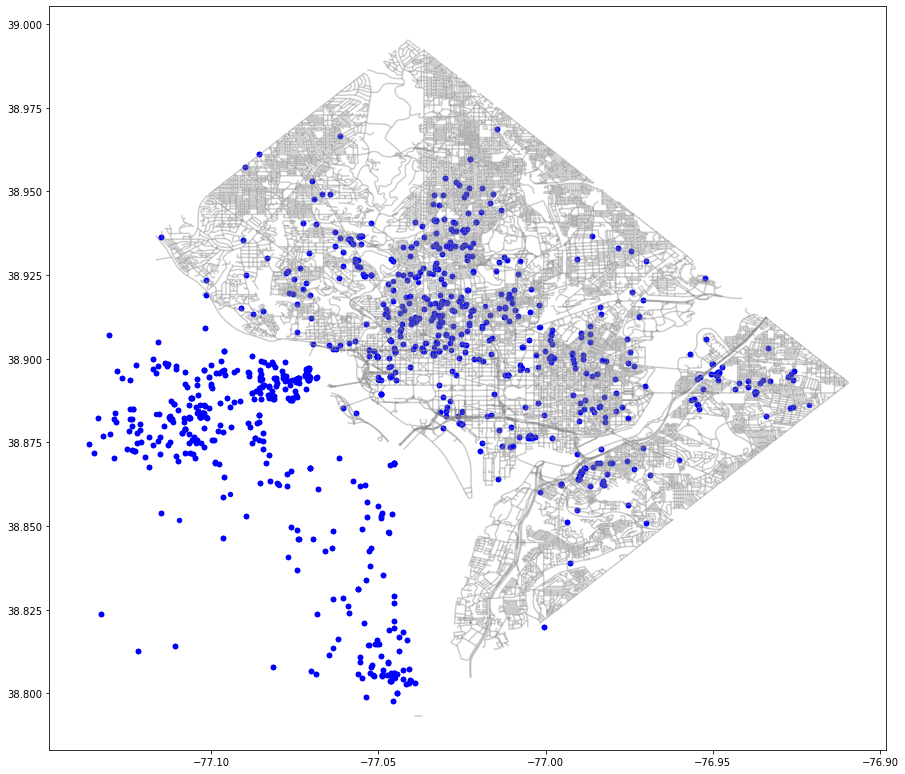

In [15]:
street_map = gpd.read_file('/Users/himanshuagarwal/BirdProject/Street_Centerlines/Street_Centerlines.shp')
gdf = gpd.GeoDataFrame(df_10_1_morning, geometry=gpd.points_from_xy(df_10_1_morning.longitude, df_10_1_morning.latitude))
fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
gdf.plot(ax=ax,markersize=20,color="blue",marker="o")
plt.show()

In [144]:
street_map.head()

OBJECTID  ROADWAYSEG STREETSEGI STREETID    SOURCEID ROADTYPE STCODE  \
0   6324990       29076       None     None  0500519202    Alley   None   
1   6324991       24398       None     None  0173447305    Alley   None   
2   6324992        1297       4883   303510    33510190   Street  03510   
3   6324993        9648       3108   103861    13861050   Street  03861   
4   6324994        4116       3650   105791    15791507   Street  05791   

  STTYPEID  QUADCODE         ST_NAME  ... TOLEFTTHEO FROMRIGHTT TORIGHTTHE  \
0     None         2            None  ...        0.0        0.0        0.0   
1     None         2            None  ...        0.0        0.0        0.0   
2      139         3      Fendall St  ...     1998.0     1901.0     1999.0   
3      139         1            G St  ...      598.0      501.0      599.0   
4       10         1  MacArthur Blvd  ...     5198.0     5101.0     5169.0   

  LIFECYCLES                INSERVICED OUTOFSERVI                UPDATETIME  \
0     Active  2004-08-27T13:42:29.000Z       None  2004-12-14T10:56:34.000Z   
1     Active  2004-08-27T13:42:28.000Z       None  2004-12-14T10:56:36.000Z   
2     Active  2004-08-27T13:42:25.000Z       None  2004-12-14T10:56:36.000Z   
3     Active  2004-08-27T13:42:26.000Z       None  2004-12-14T10:56:35.000Z   
4     Active  2004-08-27T13:42:26.000Z       None  2004-12-14T10:56:39.000Z   

  OBJECTID_1    SHAPELEN                                           geometry  
0          0   41.375292  LINESTRING (-76.92919 38.89248, -76.92962 38.8...  
1          0   96.624803  LINESTRING (-76.98117 38.90256, -76.98113 38.9...  
2          0   19.224288  LINESTRING (-76.97963 38.86550, -76.97967 38.8...  
3          0   40.603485  LINESTRING (-77.01893 38.89832, -77.01919 38.8...  
4          0  195.048300  LINESTRING (-77.10141 38.92496, -77.10146 38.9...  

[5 rows x 37 columns]

### Stationary scooters:

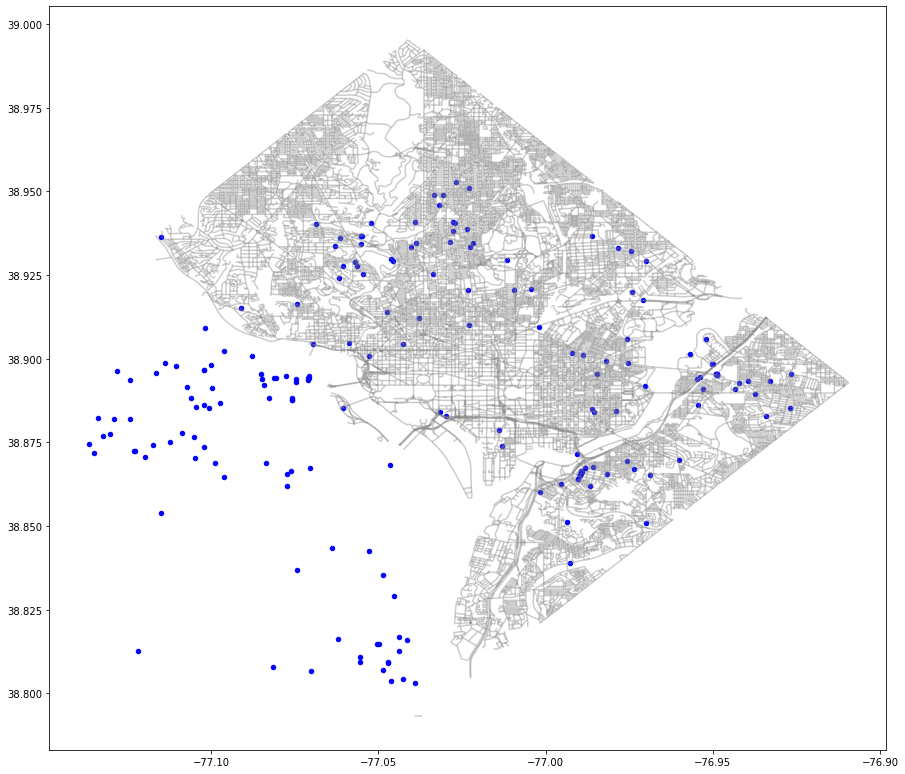

In [22]:
gdf2 = gpd.GeoDataFrame(StatScootsFinal)
fig, ax = plt.subplots(figsize = (15,15))
street_map.plot(ax = ax, alpha = 0.4, color="grey")
gdf2.plot(ax=ax,markersize=20,color="blue",marker="o")
plt.show()

## Clustering:

### Applying KMeans

In [23]:
X = StatScootsFinal[['latitude', 'longitude']].values
kmeans = KMeans(n_clusters=10)
predictions = kmeans.fit_predict(X)

clustered = pd.concat([StatScootsFinal.reset_index(), 
                       pd.DataFrame({'Cluster':predictions})], 
                      axis=1)
clustered.drop('index', axis=1, inplace=True)

### Scatter plot of clusters

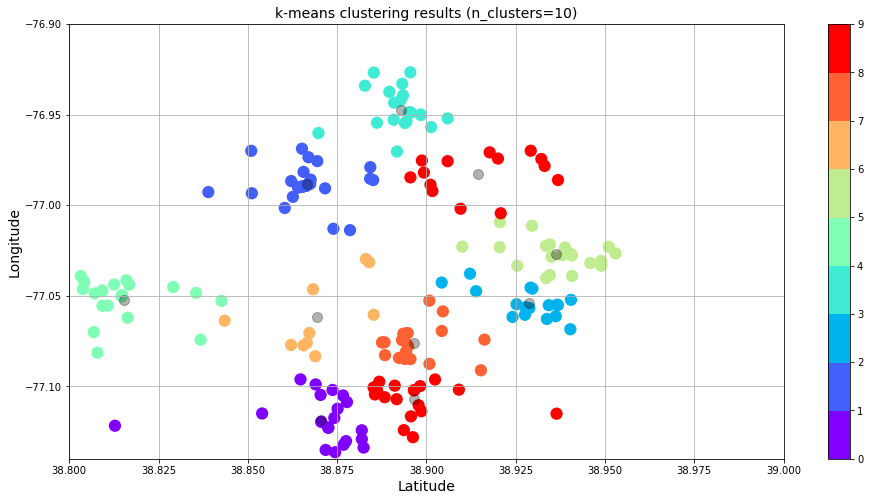

In [24]:
fig = plt.figure(figsize=(16,8))
cmap=plt.cm.rainbow
norm = matplotlib.colors.BoundaryNorm(np.arange(0,10,1), cmap.N)
plt.scatter(clustered['latitude'], clustered['longitude'], c=clustered['Cluster'],cmap=cmap, norm=norm, s=150, edgecolor='none')
plt.colorbar(ticks=np.linspace(0,9,10))
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100, alpha=0.3)
plt.xlim(38.8, 39)
plt.ylim(-77.14, -76.9)
plt.xlabel('Latitude', fontsize=14)
plt.ylabel('Longitude', fontsize=14)
plt.title('k-means clustering results (n_clusters=10)', fontsize=14)
plt.grid()
plt.show()

## Mapping of clusters

In [117]:
m = folium.Map(location=[38.95026, -77.09355])

In [68]:
for i in range(0,len(StatScootsFinal)-1):
    folium.Circle(
    location=[StatScootsFinal['latitude'].iloc[i], StatScootsFinal['longitude'].iloc[i]],
    radius=5,
    color='crimson',
    fill=False,
    ).add_to(m)


In [69]:
m

In [52]:
StatScootsFinal['latitude'].iloc[1]

38.940294

In [50]:
range(0,len(StatScootsFinal))

range(0, 198)

### Cluster mapping:

In [70]:
clustered.head()

Date  Origin_Dist      Time                          area_key  \
0  2019-10-01     1.161393  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   
1  2019-10-01     1.385419  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   
2  2019-10-01     1.421153  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   
3  2019-10-01     1.662518  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   
4  2019-10-01     1.701857  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   

   battery_level                             bounty_id  captive  code  \
0             35  a3941a05-f317-47f3-a02d-086a1213b6e8    False  None   
1             71                                  None    False  None   
2             64                                  None    False  None   
3             43                                  None    False  None   
4             63                                  None    False  None   

   estimated_range                                    id   latitude  \
0             4247  0c01616a-0fd9-4b6a-bbb0-f9964345d06f  38.936431   
1             8631  a6183867-8ab9-4d4d-9a64-580d887432aa  38.940294   
2             7809  76b5a690-ccc0-408b-9b28-0470c50c05fb  38.915246   
3             5206  944d4f77-a23a-43bd-851d-bf9ae9fe8027  38.933731   
4             7672  3ea0852a-f975-4d83-a822-57a3828f1fe8  38.916252   

   longitude model nest_id vehicle_class           date_time  \
0 -77.115090    bd    None       scooter 2019-10-01 07:00:13   
1 -77.068497    bd    None       scooter 2019-10-01 07:00:13   
2 -77.091159    bd    None       scooter 2019-10-01 07:00:13   
3 -77.062802    bd    None       scooter 2019-10-01 07:00:13   
4 -77.074220    bd    None       scooter 2019-10-01 07:00:13   

                 lats_tups                    geometry  Cluster  
0   (38.936431, -77.11509)  POINT (-77.11509 38.93643)        9  
1  (38.940294, -77.068497)  POINT (-77.06850 38.94029)        2  
2  (38.915246, -77.091159)  POINT (-77.09116 38.91525)        7  
3  (38.933731, -77.062802)  POINT (-77.06280 38.93373)        2  
4   (38.916252, -77.07422)  POINT (-77.07422 38.91625)        7

In [107]:
 colors = ['red', 'blue', 'green', 'gray'
            ,'orange', 'darkblue', 'cadetblue', 'white', 'purple', 'black']

In [118]:
for i in range(0,len(StatScootsFinal)-1):
    folium.Circle(    
    location=[StatScootsFinal['latitude'].iloc[i], StatScootsFinal['longitude'].iloc[i]],
    radius=100,
    color= colors[clustered['Cluster'].iloc[i]],
    fill=True,
    fill_color = colors[clustered['Cluster'].iloc[i]]
    ).add_to(m)

In [119]:
m

In [ ]:
# Mapping with Markers (Takes lot of time to load and slow to work with)

In [120]:
m2 = folium.Map(location=[38.95026, -77.09355])

In [121]:
for i in range(0,len(StatScootsFinal)-1):
    folium.Marker(    
    location=[StatScootsFinal['latitude'].iloc[i], StatScootsFinal['longitude'].iloc[i]],
    icon = folium.Icon(color= colors[clustered['Cluster'].iloc[i]]),
    ).add_to(m2)

In [ ]:
m2

# Extending the analysis to weeks:

## First, lets make a function to make our job easier

In [125]:
def get_statscoots(date):
    ##Fetching scooter data in the morning between 7 to 7.15am and in the night between 11.45 to 11.59pm
    global StatScoots
    df_morning = pd.DataFrame()
    df_evening = pd.DataFrame()
    df_morning = df.loc[((df['date_time']>= ''+str(date)+' 07:00:00')&(df['date_time']<= ''+str(date)+' 07:15:00'))]
    df_evening = df.loc[((df['date_time']>= ''+str(date)+' 23:45:00')&(df['date_time']<= ''+str(date)+' 23:59:00'))]
    df_morning = df_morning.reset_index(drop=True)
    df_evening = df_evening.reset_index(drop=True)
    ##Totscoots is all the unique scooter ids present in the above timeframe
    TotScootsUUID = []; TotScootsUUID= df_morning['id'].unique().tolist()
    ##To convert the format of ids from UUID in TotScootsUUID to strings in TotScoots
    TotScoots = []
    for i,n in enumerate(TotScootsUUID):
        a = TotScootsUUID[i].urn.split(':')
        TotScoots.append(a[2])
    ##Converting latitude and longitude columns to tuples
    df_morning['lats_tups'] = list(zip(df_morning['latitude'],df_morning['longitude']))
    df_evening['lats_tups'] = list(zip(df_evening['latitude'],df_evening['longitude']))
    #To make a dataframe 'lats' containing information of scooter ids and if had the
    #same coordinate throughout the day.
    df_morning['id'] = df_morning['id'].astype(str)
    df_evening['id'] = df_evening['id'].astype(str)
    lats = pd.DataFrame(columns=['id','Count of lats'])
    lens = []
    for i,n in enumerate(TotScoots):
        lens.append(n)
        lens.append(df_evening.loc[(df_evening['id']== n,'lats_tups')].nunique())
        lats = lats.append({'id':lens[0],'Count of lats':lens[1]},ignore_index=True)
        lens = []
    #No. of stationary scooters for each day:
    StatScoots = pd.DataFrame(columns=['date','id'])
    StatScootsList = lats.loc[(lats['Count of lats']==1,'id')].tolist()
    StatScoots = StatScoots.append([{'id': i, 'date':date} for i in StatScootsList],ignore_index=True)
    StatScoots['date'] = pd.to_datetime(StatScoots.date)
    StatScoots.to_sql('statbirds_dc', engine,if_exists='append',index=False)

In [126]:
#Getting no. of stationary scooters for 10/19:
get_statscoots('2019-10-19')
print(len(StatScoots))

169


# Follow random scooters throughout the day:

## Case1: Plottting 'id : 04cbf34c-3715-4fa5-b7b5-dc85692bdd29' from 10/6

In [127]:
m3 = folium.Map(location=[38.95026, -77.09355])

In [128]:
  folium.Circle(
    location=[38.875869,-77.135179],
    radius=5,
    color='crimson',
    fill=False,
    ).add_to(m3)

In [130]:
  folium.Circle(
    location=[38.875787,-77.135027],
    radius=5,
    color='crimson',
    fill=False,
    ).add_to(m3)

In [131]:
m3

## Case2: Plottting 'id : 514ad684-ba49-4eba-b2c4-69d7675acb77' from 10/11

In [138]:
m4 = folium.Map(location=[38.95026, -77.09355])

In [139]:
  folium.Circle(
    location=[38.92242339,-77.07273108],
    radius=5,
    color='crimson',
    fill=False,
    ).add_to(m4)

In [140]:
  folium.Circle(
    location=[38.922401,-77.07264],
    radius=5,
    color='crimson',
    fill=False,
    ).add_to(m4)

In [141]:
  folium.Circle(
    location=[38.922442,-77.072649],
    radius=5,
    color='crimson',
    fill=False,
    ).add_to(m4)

In [142]:
  folium.Circle(
    location=[38.922339,-77.072701],
    radius=5,
    color='crimson',
    fill=False,
    ).add_to(m4)

In [143]:
m4

# Discarding points outside D.C. area

In [207]:
boundary_map = gpd.read_file('/Users/himanshuagarwal/BirdProject/Washington_DC_Boundary/Washington_DC_Boundary.shp')

In [208]:
boundary_map.head()

OBJECTID   CITY_NAME  STATE_CITY CAPITAL            WEB_URL  AREAKM  \
0         1  Washington     1150000       Y  http://www.dc.gov  177.47   

   AREAMILES    Shape_Leng    Shape_Area  \
0      68.52  67608.276922  1.774562e+08   

                                            geometry  
0  POLYGON ((-77.11980 38.93435, -77.11979 38.934...

In [226]:
#Defining two points to check if our code corrrectly identifies if it falls inside the D.C. polygon or not:
#(For some reason, the polygon in the shapefile contains longitude value first and latitude value second, so thats
# why I have defined Point1 and Point2 with longitude value first and latitude value second)
point1 = Point(-77.129256,38.889769) #Outside D.C. point

In [232]:
point2 = Point(-77.042670,38.933543) #Inside D.C. point

In [228]:
print(point1)
print(point2)

POINT (-77.129256 38.889769)
POINT (-77.040334 38.932693)


In [222]:
poly = Polygon2(boundary_map['geometry'][0])

In [223]:
print(poly)

POLYGON ((-77.1197952245159 38.93435090401753, -77.11979491349844 38.9343511385524, -77.04096649878738 38.99596803650932, -76.90914996169623 38.8929314364726, -77.03902289145819 38.79164435125454, -77.03902264162893 38.79188239246199, -77.03904278793576 38.7932138808091, -77.03912357413404 38.79687525669821, -77.0391441585694 38.79767679118979, -77.03918532279732 38.80059096726239, -77.03899558043879 38.80162601824284, -77.03878466971099 38.80278290681536, -77.03833477371057 38.80510197041982, -77.03748328309796 38.80940577819197, -77.03705485130844 38.81098106839698, -77.03649457706105 38.812986760615, -77.03613146499542 38.81428050181683, -77.03614000151572 38.81481249548204, -77.03812910297988 38.81559638460818, -77.03813820824591 38.8156127770795, -77.03814742919117 38.81563016044589, -77.03815584354292 38.8156464630568, -77.03816425760961 38.81566222515791, -77.03817232696484 38.81567933864422, -77.03818108666927 38.81569546097042, -77.03818927175622 38.81571365543612, -77.0381972

In [237]:
#Checks to see if a point is inside the d.c. polygon or not:
print(point1.within(poly))
print(point2.within(poly))

False
True


# Where do scooters start at the beginning of the day?

## Lets try to do this for one day first (same day as previously used 10/1) :

In [238]:
df_10_1_morning.head(2)

Date  Origin_Dist      Time                          area_key  \
0  2019-10-01     0.161879  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   
1  2019-10-01     0.676361  07:00:13  F461754DC547D80D5B8E77A5018FC6E8   

   battery_level bounty_id  captive  code  estimated_range  \
0             40      None    False  None             4932   
1             28      None    False  None             3425   

                                     id   latitude  longitude model nest_id  \
0  698e5a3d-6811-42a8-b27d-546a38ebe4a4  38.935482 -77.090567    bd    None   
1  01daf91b-5a31-4b1f-b16f-d3a0f131cb53  38.930202 -77.083211    bd    None   

  vehicle_class           date_time                lats_tups  \
0       scooter 2019-10-01 07:00:13  (38.935482, -77.090567)   
1       scooter 2019-10-01 07:00:13  (38.930202, -77.083211)   

                     geometry  
0  POINT (-77.09057 38.93548)  
1  POINT (-77.08321 38.93020)

In [ ]:
#Using Folium to map the scooters:
morningscooters = folium.Map(location=[38.95026, -77.09355])

In [ ]:
for i in range(0,len(StatScootsFinal)-1):
    folium.Circle(    
    location=[StatScootsFinal['latitude'].iloc[i], StatScootsFinal['longitude'].iloc[i]],
    radius=100,
    color= colors[clustered['Cluster'].iloc[i]],
    fill=True,
    fill_color = colors[clustered['Cluster'].iloc[i]]
    ).add_to(morningscooters)